In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn, fourier_coefficients, inverse_fourier
from sdebridge.data_processing import sample_ellipse

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
Nt=50
dim=2
N = 4
alpha = 0.5
sigma = 0.2
Ngrid = 10
grid_range = (-1., 1.)
Npt = 100

sde = sdes.fourier_gaussian_kernel_sde(T, Nt, dim, N, alpha, sigma, Ngrid, grid_range, Npt)

In [4]:
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')

initial_coeffs = fourier_coefficients(initial_butterfly, N)
target_coeffs = fourier_coefficients(target_butterfly, N)


ellipse_pts_target = sample_ellipse(Npt, scale=0.5)
ellipse_target = fourier_coefficients(ellipse_pts_target, N)

ellipse_pts_init = sample_ellipse(Npt, scale=0.7)
ellipse_init = fourier_coefficients(ellipse_pts_init, N)

In [5]:
print(f"{ellipse_target.shape=}")

ellipse_target.shape=(2, 4, 2)


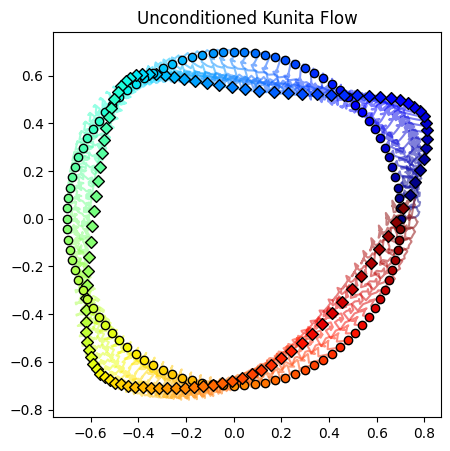

In [6]:
from sdebridge.plotting import plot_single_trajectory

key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(sde, ellipse_init, 64, key)
forward_traj_coeffs = forward_trajs[1]
forward_traj = inverse_fourier(forward_traj_coeffs, 100)
traj = forward_traj.reshape((-1, Npt*dim))
plot_single_trajectory(traj, "Unconditioned Kunita Flow")

In [7]:
from sdebridge.networks.score_unet import ScoreUNet

net = ScoreUNet

network = {
    "output_dim": sde.dim*sde.n_bases*2,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    
training = {
    "batch_size": 64,
    "load_size": 100*64,
    "num_epochs": 100,
    "learning_rate": 2e-3,
    "warmup_steps": 1000,
}

# target = ellipse_target

train_key = jax.random.split(key, 2)[0]
score_p_state = db.learn_p_score(sde, ellipse_init, train_key, **training, net=net, network_params=network)

Training: 100%|██████████| 100/100 [11:25<00:00,  6.86s/epoch, Epoch=100, loss=352.9205]


In [8]:
reverse_sde = sdes.reverse(sde, score_fn(score_p_state))
backward_coeffs = sdes.simulate_traj(reverse_sde, ellipse_target, 2, key)
# forward_coeffs = sdes.simulate_traj(sde, ellipse_init, 2, key)

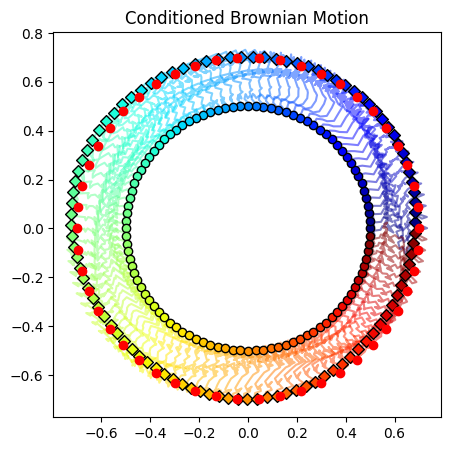

In [9]:
backward_traj = inverse_fourier(backward_coeffs[0], 100)
traj = backward_traj.reshape((-1, Npt*dim))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(ellipse_init, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="r", zorder=2)

# ellipse = sample_ellipse(Npt, shifts=jnp.array([0.2, 0]), scale=0.5)
# plt.scatter(ellipse[:, 0], ellipse[:, 1], c="g")


# forward_traj = inverse_fourier(forward_coeffs[0], 100)
# traj = forward_traj.reshape((-1, Npt*dim))
# plot_single_trajectory(traj, "Unconditioned Brownian Motion")

(2, 50, 2, 4, 2)


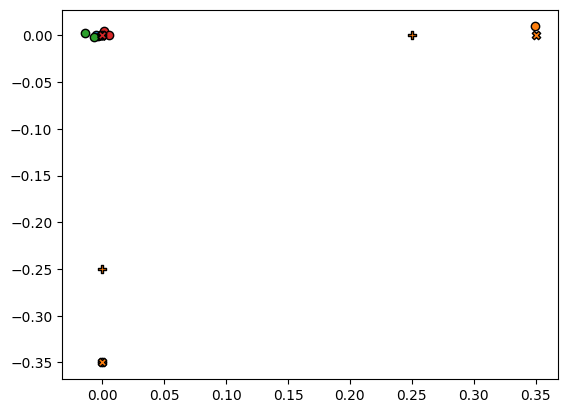

In [10]:

plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(N)):
    plt.scatter(plt_backward_coeffs[-1, 0, coeff, 0], plt_backward_coeffs[-1, 0, coeff, 1], color=f"C{i}", edgecolors="k")
    plt.scatter(plt_backward_coeffs[-1, 1, coeff, 0], plt_backward_coeffs[-1, 1, coeff, 1], color=f"C{i}", edgecolors="k")
    plt.scatter(plt_backward_coeffs[0, 0, coeff, 0], plt_backward_coeffs[0, 0, coeff, 1], color=f"C{i}", marker="P", edgecolors="k")
    plt.scatter(plt_backward_coeffs[0, 1, coeff, 0], plt_backward_coeffs[0, 1, coeff, 1], color=f"C{i}", marker="P", edgecolors="k")
    # plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(ellipse_init[0, coeff, 0], ellipse_init[0, coeff, 1], color=f"C{i}", marker="X", edgecolors="k")
    plt.scatter(ellipse_init[1, coeff, 0], ellipse_init[1, coeff, 1], color=f"C{i}", marker="X", edgecolors="k")